# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

1- Problem statement:

This study is about mimic data about a Starbucks advertisement where 2 offers were sent to customers about a drink, Bogo and Discount. 3 questions will be answered, which part of the population best responded to the advertisement, which advertisement was most successful and how can we predict if an advertisement suucceeded or was completed.

In [9]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

2- Data Cleaning and preparation:

Understanding and preparing the portfolio dataset:

In [10]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [11]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [5]:
portfolio.shape

(10, 6)

In [12]:
portfolio.rename(columns = {'id':'offer_id'}, inplace = True)

In [5]:
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


Understanding and preparing the profile dataset:

In [13]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [8]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [11]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

Renaming and reformating dataset:

In [14]:
profile.rename(columns = {'id':'customer_id'}, inplace = True)

In [15]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')

In [16]:
profile['membership_year'] = profile['became_member_on'].dt.year

In [17]:
del(profile['became_member_on'])

In [11]:
profile.head()

,age,gender,customer_id,income,membership_year
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
4,118,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017


Understanding and preparinf the transcript dataset:

In [18]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [19]:
transcript.rename(columns = {'person':'customer_id'}, inplace = True)

In [19]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event          306534 non-null object
customer_id    306534 non-null object
time           306534 non-null int64
value          306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [20]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


Categorical variables for event column:

In [20]:
transcript = pd.get_dummies(transcript , columns=['event'])

In [22]:
transcript.drop(transcript[transcript['event_transaction'] == 1].index, inplace=True)

In [62]:
transcript.head()

,customer_id,time,event_offer completed,event_offer received,event_offer viewed,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [23]:
del transcript['event_transaction']

In [17]:
transcript.head()

,customer_id,time,value,event_offer completed,event_offer received,event_offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0
2,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0


Creating the offer_id column:

In [24]:
transcript['offer_id'] = transcript.value.apply(lambda x:list(x.values())[0])

In [25]:
del transcript['value']

In [63]:
transcript.head()

,customer_id,time,event_offer completed,event_offer received,event_offer viewed,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0


3- EDA:

Histogram for age distribution:

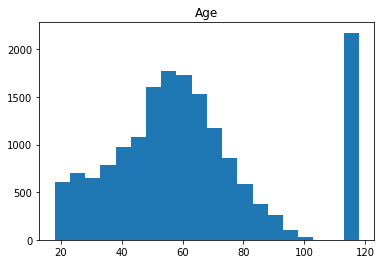

In [31]:
plt.hist(profile['age'], bins = 20);
plt.title('Age');

In [26]:
profile.drop(profile[profile['age'] == 118].index, inplace=True)

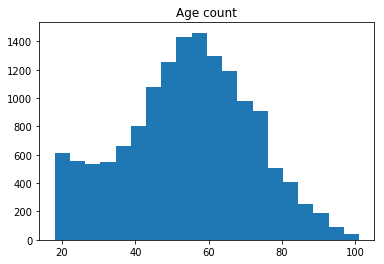

In [21]:
plt.hist(profile['age'], bins = 20);
plt.title('Age count');

Most of the population seems to age between 45 and 65 years with a median and a mean that are close, the distribution is close to be a normal distribution.

Histogram for gender distribution:

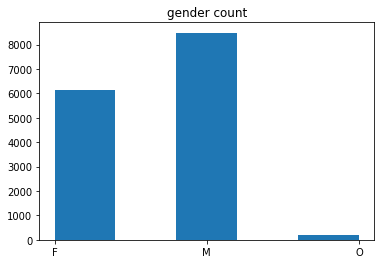

In [34]:
plt.hist(profile['gender'], bins = 5);
plt.title('gender count');

The Male part of the population exceeds the Female part largely by approximatly 2000 individuals, 12%.

Histogram for income distribution:

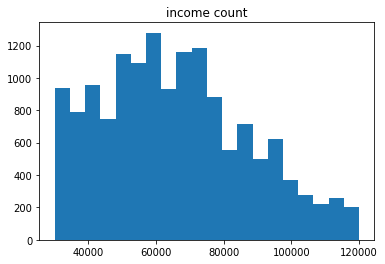

In [35]:
plt.hist(profile['income'], bins = 20);
plt.title('income count');

Most of the population seems to earn between 55000 and 80000 USD with a peack at 60000 USD.

Histogram for membership:

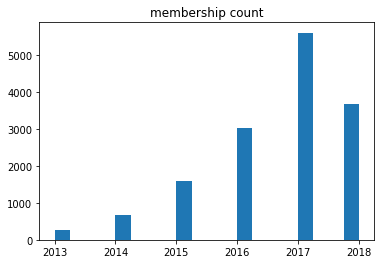

In [36]:

plt.hist(profile['membership_year'], bins = 20);
plt.title('membership count');

All membership are between 2013 and 2018 with a peack in 2017

Merging the 2 datasets transcript and profile:

In [27]:
data = pd.merge(transcript , profile ,on='customer_id', how='inner')

In [64]:
data.head()

,customer_id,time,event_offer completed,event_offer received,event_offer viewed,offer_id,age,income,membership_year,difficulty,duration,reward,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
0,0,0,0,1,0,0,75,100000.0,2017,5,7,5,1,0,0,1,0,0
1,0,6,0,0,1,0,75,100000.0,2017,5,7,5,1,0,0,1,0,0
2,0,132,1,0,0,0,75,100000.0,2017,5,7,5,1,0,0,1,0,0
3,0,168,0,1,0,1,75,100000.0,2017,0,3,0,1,0,0,0,0,1
4,0,216,0,0,1,1,75,100000.0,2017,0,3,0,1,0,0,0,0,1


In [39]:
data.shape

(148805, 10)

Exploring data according to age:

In [2]:
def age_segmentation(data):
    
    '''input dataframe data
       output percent of completed offers to generated offers according to age segmentation'''
    
    age1 = data[data['age'] < 30]
    age2 = data[(data['age'] > 30) & (data['age'] < 60)]
    age3 = data[(data['age'] > 60) & (data['age'] < 90)]
    age4 = data[(data['age'] > 90) & (data['age'] < 120)]
    per1 = age1[age1['event_offer completed'] == 1].count()['event_offer completed']
    per2 = age2[age2['event_offer completed'] == 1].count()['event_offer completed']
    per3 = age3[age3['event_offer completed'] == 1].count()['event_offer completed']
    per4 = age4[age4['event_offer completed'] == 1].count()['event_offer completed']
    perc1 = per1/age1.shape[0]*100
    perc2 = per2/age2.shape[0]*100
    perc3 = per3/age3.shape[0]*100
    perc4 = per4/age4.shape[0]*100
    
    return perc1, perc2, perc3, perc4



In [29]:
age_segmentation(data)

(18.390648362104116,
 21.761445288441799,
 22.782472438300967,
 23.131357806280405)

well percentage of completed offers or responded advetisements by age are 18% 21% 22% and 23% respectivly according to people between 0 and 30 years, 30 and 60 years, 60 and 90 years and more than 90 years. It seems that the advertisement mostly succeded on people above 90 years.

Exploring data according to income:

In [3]:
def income_segmentation(data):
    '''input dataframe data
       output percent of completed offers to generated offers according to income segmentation'''
    
    income1 = data[(data['income'] < 30000)]
    income2 = data[(data['income'] > 30000) & (data['income'] < 60000)]
    income3 = data[(data['income'] > 60000) & (data['income'] < 90000)]
    income4 = data[(data['income'] > 90000) & (data['income'] < 120000)]
    income5 = data[(data['age'] > 120000)]
    incper1 = income1[income1['event_offer completed'] == 1].count()['event_offer completed']
    incper2 = income2[income2['event_offer completed'] == 1].count()['event_offer completed']
    incper3 = income3[income3['event_offer completed'] == 1].count()['event_offer completed']
    incper4 = income4[income4['event_offer completed'] == 1].count()['event_offer completed']
    incper5 = income5[income5['event_offer completed'] == 1].count()['event_offer completed']
    incperc1 = incper1/income1.shape[0]*100
    incperc2 = incper2/income2.shape[0]*100
    incperc3 = incper3/income3.shape[0]*100
    incperc4 = incper4/income4.shape[0]*100
    incperc5 = incper5/income5.shape[0]*100
    
    return incperc1, incperc2, incperc3, incperc4, incperc5 

In [31]:
income_segmentation(data)

(nan, 18.842607836680937, 23.209586388387759, 26.043303649380128, nan)

well percentage of completed offers or responded advetisements by income are 18% for people with income between 30000 and 60000 USD, 23% for people with income between 60000 and 90000 USD, 26% for people with income between 90000 and 120000 USD. People best responded to the advertisement in the high income brackets.

Exploring data according to gender:

In [4]:
def gender_segmentation(data):
    '''input dataframe data
       output percent of completed offers to generated offers according to income segmentation'''
    
    gender1 = data[(data['gender'] == 'F')]
    gender2 = data[(data['gender'] == 'M')]
    genper1 = gender1[gender1['event_offer completed'] == 1].count()['event_offer completed']
    genper2 = gender2[gender2['event_offer completed'] == 1].count()['event_offer completed']
    genperc1 = genper1/gender1.shape[0]*100
    genperc2 = genper2/gender2.shape[0]*100
    
    return genperc1, genperc2

In [33]:
gender_segmentation(data)

(24.289458403301996, 19.863443350704497)

Women responded better to the offer than men, 24% to 19%.

Merging the 3 datasets together:

In [34]:
data = data.merge(portfolio, on='offer_id', how='left')
data

,customer_id,time,event_offer completed,event_offer received,event_offer viewed,offer_id,age,gender,income,membership_year,channels,difficulty,duration,offer_type,reward
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,F,100000.0,2017,"[web, email, mobile]",5,7,bogo,5
1,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,F,100000.0,2017,"[web, email, mobile]",5,7,bogo,5
2,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,F,100000.0,2017,"[web, email, mobile]",5,7,bogo,5
3,78afa995795e4d85b5d9ceeca43f5fef,168,0,1,0,5a8bc65990b245e5a138643cd4eb9837,75,F,100000.0,2017,"[email, mobile, social]",0,3,informational,0
4,78afa995795e4d85b5d9ceeca43f5fef,216,0,0,1,5a8bc65990b245e5a138643cd4eb9837,75,F,100000.0,2017,"[email, mobile, social]",0,3,informational,0
5,78afa995795e4d85b5d9ceeca43f5fef,408,0,1,0,ae264e3637204a6fb9bb56bc8210ddfd,75,F,100000.0,2017,"[email, mobile, social]",10,7,bogo,10
6,78afa995795e4d85b5d9ceeca43f5fef,408,0,0,1,ae264e3637204a6fb9bb56bc8210ddfd,75,F,100000.0,2017,"[email, mobile, social]",10,7,bogo,10
7,78afa995795e4d85b5d9ceeca43f5fef,504,0,1,0,f19421c1d4aa40978ebb69ca19b0e20d,75,F,100000.0,2017,"[web, email, mobile, social]",5,5,bogo,5
8,78afa995795e4d85b5d9ceeca43f5fef,510,1,0,0,ae264e3637204a6fb9bb56bc8210ddfd,75,F,100000.0,2017,"[email, mobile, social]",10,7,bogo,10
9,78afa995795e4d85b5d9ceeca43f5fef,510,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,75,F,100000.0,2017,"[web, email, mobile, social]",5,5,bogo,5


Exploring the Bogo Discount advertisement:

In [5]:
def bogo_segmentation(data):
    '''input dataframe data
       output percent of completed offers to generated offers according to the kind of advertisement sent'''
    
    bogo1 = data[(data['offer_type'] == 'bogo')]
    discount1 = data[(data['offer_type'] == 'discount')]
    bogoper1 = bogo1[bogo1['event_offer completed'] == 1].count()['event_offer completed']
    discountper1 = discount1[discount1['event_offer completed'] == 1].count()['event_offer completed']
    bogoperc1 = bogoper1/bogo1.shape[0]*100
    discountperc1 = discountper1/discount1.shape[0]*100
    
    return bogoperc1, discountperc1

In [36]:
bogo_segmentation(data)

(23.902622426919823, 27.581004958996004)

It seems that the Discount advertisement succeeded better than the Bogo advertisement, 23% to 27% but the 2 advertisements succeeded well. 

4-Modeling:

Data preparation for the model:

Processing offer_id and customer_id for the Machine learning model:

In [37]:
offerbits = data['offer_id'].unique().tolist()
o_mapping = dict( zip(offerbits,range(len(offerbits))) )
data.replace({'offer_id': o_mapping},inplace=True)

In [38]:
cusbits = data['customer_id'].unique().tolist()
c_mapping = dict( zip(cusbits,range(len(cusbits))) )
data.replace({'customer_id': c_mapping},inplace=True)

In [39]:
data = pd.get_dummies(data , columns=['gender'])

In [40]:
del data['channels']

In [41]:
data = pd.get_dummies(data , columns=['offer_type'])

In [42]:
data

,customer_id,time,event_offer completed,event_offer received,event_offer viewed,offer_id,age,income,membership_year,difficulty,duration,reward,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
0,0,0,0,1,0,0,75,100000.0,2017,5,7,5,1,0,0,1,0,0
1,0,6,0,0,1,0,75,100000.0,2017,5,7,5,1,0,0,1,0,0
2,0,132,1,0,0,0,75,100000.0,2017,5,7,5,1,0,0,1,0,0
3,0,168,0,1,0,1,75,100000.0,2017,0,3,0,1,0,0,0,0,1
4,0,216,0,0,1,1,75,100000.0,2017,0,3,0,1,0,0,0,0,1
5,0,408,0,1,0,2,75,100000.0,2017,10,7,10,1,0,0,1,0,0
6,0,408,0,0,1,2,75,100000.0,2017,10,7,10,1,0,0,1,0,0
7,0,504,0,1,0,3,75,100000.0,2017,5,5,5,1,0,0,1,0,0
8,0,510,1,0,0,2,75,100000.0,2017,10,7,10,1,0,0,1,0,0
9,0,510,1,0,0,3,75,100000.0,2017,5,5,5,1,0,0,1,0,0


In [73]:
data.shape

(148805, 18)

Split train ans test data:

In [43]:

X = data.drop('event_offer completed', axis=1)
y = data['event_offer completed']

In [44]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Training and testing:

Metrics:

The F1 score will be considered for testing the well being of the models considering precision and recall.

KNeighborsClassifier:
K-Nearest Neighbour algorithm was used here to predict if offers were completred or not, model will be tested according to F1 score

In [45]:

model1 = KNeighborsClassifier()
model1.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [41]:
print('offer completed F1_score {}'.format( model1.score(X_train,y_train)))
print('offer completed Test F1_score {}'.format(model1.score(X_test,y_test)))

offer completed F1_score 0.7953370429110329
offer completed Test F1_score 0.7419224772861674


It seems that scores were good for the tested and the trained sets, 79% and 74%. The model fitted exactly we can predict.

AdaBoost Classifier:
AdaBoost Classifier algorithm was used here to predict if offers were completred or not, model will be tested according to F1 score

In [46]:
model2 = AdaBoostClassifier()
model2.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [47]:
print('offer completed F1_score {}'.format( model2.score(X_train,y_train)))
print('offer completed Test F1_score {}'.format(model2.score(X_test,y_test)))

offer completed F1_score 1.0
offer completed Test F1_score 1.0


It seems that scores were perfect for the tested and the trained sets, 100% and 100%. The model fitted exactly we can predict.

DecisionTreeClassifier:
Decision Tree  Classifier algorithm was used here to predict if offers were completred or not, model will be tested according to F1 score

In [48]:
model3 = DecisionTreeClassifier(random_state = 10)
model3.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=10,
            splitter='best')

In [49]:
print('offer completed F1_score {}'.format( model3.score(X_train,y_train)))
print('offer completed Test F1_score {}'.format(model3.score(X_test,y_test)))

offer completed F1_score 1.0
offer completed Test F1_score 1.0


It seems that scores were perfect for the tested and the trained sets, 100% and 100%. The model fitted exactly we can predict

Improvements:

The K-Nearest Neighbors model was used for further improvment as it is the safiest:
Nearest Neighbors plot on the graph were augmented from 5 to 10 to have a better control of the different fields and segmentation of the graph.

In [51]:
model4 = KNeighborsClassifier(n_neighbors = 10)
model4.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [52]:
print('offer completed F1_score {}'.format( model4.score(X_train,y_train)))
print('offer completed Test F1_score {}'.format(model4.score(X_test,y_test)))

offer completed F1_score 0.7828552995887207
offer completed Test F1_score 0.777377560346218


The model was improved by this manipulation, F1 score were better, 78% for trained and tested data. Now we can use this model to predict.

prediction:

In [60]:
predict = model4.predict(X_test[0:30])

In [61]:
predict

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0], dtype=uint8)

It seems that on the first 30 values of the test interval, 1 presented advertisement was completed but the model doesn't say if it was a Bogo or Discount advertisement.

5- Conclusion:
In the conclusion we are going to answer the 3 questions stated in the introduction. The best targeted bracket of respondants for the advertisement are people above 60 years, prefered Female and with income exceeding 60000 USD. The Discount advertisement succeded better than the Bogo advertisement and we have a model that can predict if advertisements succeeded with a completion according to all the demographic and economics inputs of the provided datasets.